# Data Preparation

The original dataset (https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data) includes 12 csv files, which are recordings of weather data of 12 different stations in Beijing. Since the "station" column for each csv file is the same, we can concat all 12 csv files into one dataframe.

In [ ]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#authorize your google collab to open files from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
copied_path = '/content/drive/Shareddrives/COGS 109 Project/prsa_combined.csv'
prsa_combined = pd.read_csv(copied_path)

In [ ]:
prsa_combined.shape

(420768, 18)

In [ ]:
prsa_combined.isnull().sum()

No             0
year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

In [ ]:
# prsa_shuffled = prsa_combined.dropna().sample(frac=1).reset_index(drop=True)
# prsa = prsa_shuffled[:110000]
# prsa

In [ ]:
prsa = prsa_combined.groupby(['year', 'month', 'day']).mean().reset_index()

In [ ]:
prsa.head()

,year,month,day,No,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,2013,9,23,4956.5,11.5,28.111111,43.416667,4.694675,37.033517,756.097561,15.568676,15.904514,1012.626389,9.670833,0.470833,1.746875
1,2015,5,13,19284.5,11.5,60.281250,137.100694,4.656140,68.683099,775.704225,76.795053,21.561111,988.867708,7.584028,0.000000,1.453472
2,2013,7,15,3276.5,11.5,42.738636,28.570370,3.679269,33.419447,1180.357143,17.864388,23.916319,993.219444,23.466667,2.429861,0.944444
3,2015,12,28,24780.5,11.5,108.191638,115.926829,21.496503,76.329861,2266.783217,7.818182,-3.805903,1029.248264,-10.646181,0.000000,1.181944
4,2015,11,13,23700.5,11.5,204.181185,205.348432,14.362369,68.472028,3043.356643,2.901754,6.978819,1016.791319,4.785764,0.000000,0.973611


# Data Exploration

## Scatter Matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f636b6fb320>,
      dtype=object)

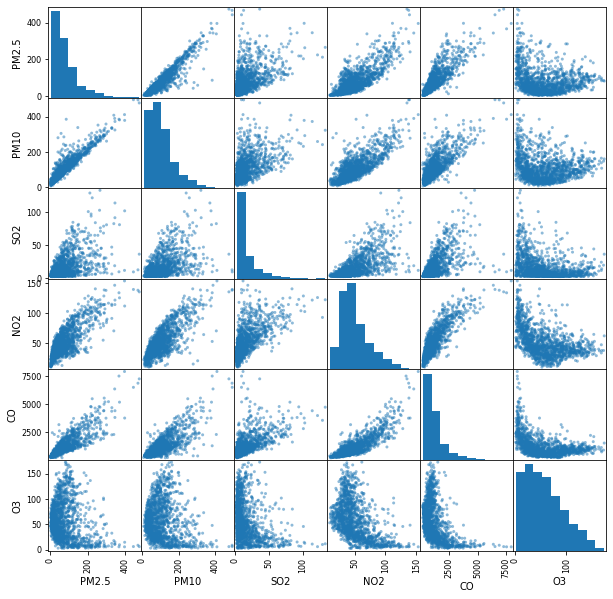

In [ ]:
pd.plotting.scatter_matrix(prsa[['PM2.5', 'PM10', 'SO2', 'NO2','CO', 'O3']], alpha=0.5, figsize=(10, 10), )

## Train/Test Split

In [ ]:
prsa = prsa.sample(frac=1).reset_index(drop=True)
y_train = prsa['PM2.5'][:1200]
y_test = prsa['PM2.5'][1200:]

## Air quality vs. time goes

### Potential Model:

$\textrm{PM2.5} = w_0 + w_1 * \textrm{days from the first year}$

We can calculate the days by doing the combined days.

In [ ]:
PM2_5_avg_day = prsa.get(['PM2.5', 'year', 'month', 'day']).groupby(['year', 'month', 'day']).mean()

Initial day is 2013, 3, 1. We will set the initial day as day 0. later day is the day difference fromt the initial day.

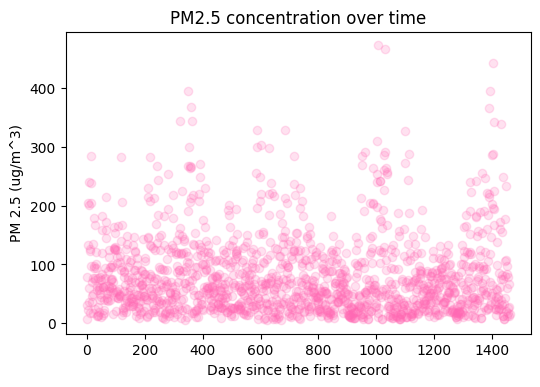

In [ ]:
datetime_day = [(datetime(*ele) - datetime(2013, 3, 1)).days for ele in PM2_5_avg_day.index]
PM2_5_avg_day = PM2_5_avg_day.assign(diff_days = datetime_day)
plt.figure(dpi=100)
plt.scatter(x=PM2_5_avg_day.get('diff_days'), y=PM2_5_avg_day.get('PM2.5'), alpha=0.2, color='hotpink')
plt.xlabel('Days since the first record')
plt.ylabel('PM 2.5 (ug/m^3)')
plt.title('PM2.5 concentration over time')
plt.show()

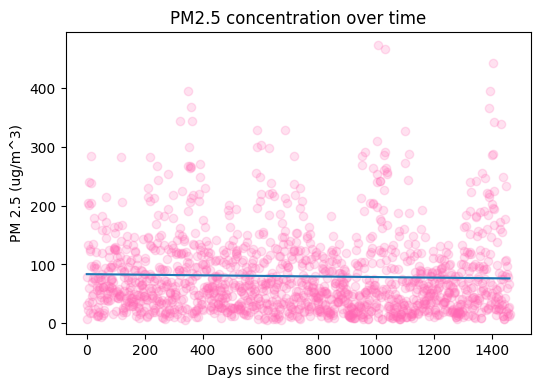

In [ ]:
#add the prediction line to it 

M25_daily = PM2_5_avg_day.get('PM2.5').to_numpy()
PM25_days = PM2_5_avg_day.get('diff_days').to_numpy()

y_val = PM25_daily.reshape(len(PM25_daily))
A1 = np.append([[1] for _ in range(len(PM25_days))], PM25_days.reshape(len(PM25_days), 1), axis=1)

# slove for w, the weight vector
w1 = np.linalg.lstsq(A1, y_val, rcond=None)[0]

plt.figure(dpi=100)
plt.scatter(x=PM2_5_avg_day.get('diff_days'), y=PM2_5_avg_day.get('PM2.5'), alpha=0.2, color='hotpink')
plt.xlabel('Days')
plt.ylabel('PM 2.5')
plt.title('Air Quality')

m1 = lambda x: w1[0] + w1[1] * x
line = [i for i in np.arange(0, max(PM25_days), 0.1)]

plt.plot(line, list(map(m1, line)), label='Model 1',)
plt.xlabel('Days since the first record')
plt.ylabel('PM 2.5 (ug/m^3)')
plt.title('PM2.5 concentration over time')
plt.show()

# Data Modelling

In [ ]:
def select_feature(lst):
    '''
    Take in a list of column name,
    Perform single degree linear regression on all columns with a biased term,
    Print the R^2 score, and mean squared error of the model made from the feature input.
    '''
    #select feature list
    feature = np.array(prsa[lst])
    X_train = feature[:1200]
    X_test = feature[1200:]

    #add biased column 1 to the train, test feature
    def add_bias(data): return np.hstack((np.ones(len(data)).reshape(len(data), 1), data))
    X_train, X_test = add_bias(X_train), add_bias(X_test)

    #generated weight
    weights = np.linalg.lstsq(X_train, y_train, rcond=None)[0]
    
    #calculate the predicted values
    preds = X_test.T[0] * weights[0]
    for i in range(len(weights)):
        if i != 0:
            preds += X_test.T[i] * weights[i]

    return (lst, r2_score(y_test, preds), mean_squared_error(y_test, preds))

In [ ]:
all_features = ['year', 'month', 'day', 'No', 'hour', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
pd.DataFrame([select_feature([i]) for i in all_features], columns = ['Feature', 'R^2', 'Mean Squared Error'])

,Feature,R^2,Mean Squared Error
0,[year],0.002655,4890.439733
1,[month],-0.000800,4907.384297
2,[day],0.000070,4903.118056
3,[No],0.002571,4890.851613
4,[hour],-0.000003,4903.476112
5,[PM10],0.884412,566.779301
6,[SO2],0.333521,3268.052664
7,[NO2],0.652700,1702.970615
8,[CO],0.737811,1285.632717
9,[O3],0.040753,4703.632373


## Baseline model (use Feature = 1)

In [ ]:
use_n_features(1).head()

,Features Used,R^2,Mean Square Error
5,[PM10],0.884412,566.779301
8,[CO],0.737811,1285.632717
7,[NO2],0.652700,1702.970615
6,[SO2],0.333521,3268.052664
14,[WSPM],0.181957,4011.244043


## Using More Feature

In [ ]:
use_n_features(2).head()

,Features Used,R^2,Mean Square Error
62,"[PM10, CO]",0.922751,378.788957
68,"[PM10, WSPM]",0.903191,474.697564
61,"[PM10, NO2]",0.898105,499.636819
63,"[PM10, O3]",0.889272,542.951964
65,"[PM10, PRES]",0.887406,552.101289


In [ ]:
#waning: starting to take a while to run
use_n_features(6)

,Features Used,R^2,Mean Square Error
3138,"[month, PM10, CO, TEMP, PRES, DEWP]",0.942853,280.219598
3141,"[month, PM10, CO, TEMP, DEWP, RAIN]",0.942136,283.732178
560,"[year, month, PM10, CO, TEMP, DEWP]",0.942035,284.231181
2672,"[month, No, PM10, CO, TEMP, DEWP]",0.942025,284.279357
2882,"[month, hour, PM10, CO, TEMP, DEWP]",0.941982,284.487289
...,...,...,...
755,"[year, day, No, hour, PRES, RAIN]",0.007988,4864.290007
7,"[year, month, day, No, hour, DEWP]",0.007388,4867.231997
8,"[year, month, day, No, hour, RAIN]",0.006481,4871.679635
50,"[year, month, day, No, PRES, RAIN]",0.005857,4874.739287


In [ ]:
#Too many features increase the mean squared error
use_n_features(10)

,Features Used,R^2,Mean Square Error
2697,"[month, hour, PM10, CO, O3, TEMP, PRES, DEWP, ...",0.942359,282.640932
1204,"[year, month, hour, PM10, CO, TEMP, PRES, DEWP...",0.942358,282.642926
1199,"[year, month, hour, PM10, CO, O3, TEMP, PRES, ...",0.942358,282.647310
2574,"[month, No, hour, PM10, CO, O3, TEMP, PRES, DE...",0.942344,282.712776
2579,"[month, No, hour, PM10, CO, TEMP, PRES, DEWP, ...",0.942344,282.713164
...,...,...,...
247,"[year, month, day, No, hour, O3, TEMP, PRES, D...",0.368419,3096.934425
249,"[year, month, day, No, hour, O3, TEMP, DEWP, R...",0.355984,3157.906342
246,"[year, month, day, No, hour, O3, TEMP, PRES, D...",0.332656,3272.293669
248,"[year, month, day, No, hour, O3, TEMP, PRES, R...",0.324778,3310.926731


# Final Result / Comparisons

In [ ]:
#this will actually take a min to run, do not re-run lol

records = []
for i in range(len(all_features)):
    records.append([i] + list(use_n_features(i).iloc[0]))

In [ ]:
def use_n_features(n):
    '''
    Try the combination of n features, and return a dataframe sorted by their R^2 value
    '''
    scores = []
    #find all the combinations of n features 
    for i in list(itertools.combinations(all_features, n)):
        scores.append(select_feature(list(i)))

    scores = pd.DataFrame(scores, columns = ['Features Used', 'R^2', 'Mean Square Error'])
    return scores.sort_values(['R^2'], ascending=False)
    

record_df = pd.DataFrame(records, columns = ['Number of feaure used', 'Best Feature Combination', 'R^2 Score', 'Mean Squared Error'])[1:]
record_df


,Number of feaure used,Best Feature Combination,R^2 Score,Mean Squared Error
1,1,[PM10],0.884412,566.779301
2,2,"[PM10, CO]",0.922751,378.788957
3,3,"[PM10, CO, DEWP]",0.931512,335.828321
4,4,"[PM10, CO, TEMP, DEWP]",0.940624,291.150063
5,5,"[month, PM10, CO, TEMP, DEWP]",0.941982,284.487289
6,6,"[month, PM10, CO, TEMP, PRES, DEWP]",0.942853,280.219598
7,7,"[month, PM10, CO, TEMP, PRES, DEWP, RAIN]",0.942941,279.784157
8,8,"[month, hour, PM10, CO, TEMP, PRES, DEWP, RAIN]",0.942941,279.784157
9,9,"[year, month, hour, PM10, CO, TEMP, PRES, DEWP...",0.942900,279.985417
10,10,"[month, hour, PM10, CO, O3, TEMP, PRES, DEWP, ...",0.942359,282.640932


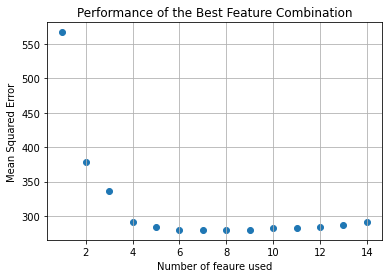

In [ ]:
plt.scatter(record_df['Number of feaure used'], record_df['Mean Squared Error'])
plt.xlabel('Number of feaure used')
plt.ylabel('Mean Squared Error')
plt.grid()
plt.title('Performance of the Best Feature Combination')
plt.show()